In [2]:
%load_ext autoreload
%autoreload 2

import os
import warnings

warnings.filterwarnings("ignore")
os.chdir("../")

In [3]:
import pandas as pd
import numpy as np

In [4]:
nft_trades = pd.read_csv("historic_data/profits.csv", low_memory=False).set_index(
    ["nft_id", "trade_no"]
)
nft_trades["holding_period"] = pd.to_timedelta(nft_trades["holding_period"]).dt.days
nft_trades["sell_date"] = pd.to_datetime(nft_trades["sell_date"])
nft_trades["purchase_date"] = pd.to_datetime(nft_trades["purchase_date"])

# Set max USD profit and max ETH profit to 100x
nft_trades_outlier_reduced = nft_trades[(nft_trades["profit_usd"] < 100) & (nft_trades["profit_eth"] < 100)]
nft_trades_100x = nft_trades[(nft_trades["profit_usd"] >= 100) & (nft_trades["profit_eth"] >= 100)]

In [5]:
df = pd.DataFrame(nft_trades["profit_usd"], index = nft_trades.index)
a = 0
for i in [0.1, 0.5, 1, 10, 100, np.inf]:
    df[str(a)+"_"+str(i)] = nft_trades[nft_trades["purchase_price_eth"].between(a,i, inclusive="left")]["profit_usd"]
    a = i
df = df.set_index("profit_usd").isna().replace({True: 0, False: 1})

In [9]:
df

,0_0.1,0.1_0.5,0.5_1,1_10,10_100,100_inf
profit_usd,,,,,,
0.152352,0,0,0,1,0,0
2.147954,0,0,0,1,0,0
1.423239,0,0,0,1,0,0
-0.296476,0,0,0,0,1,0
2.730662,0,0,0,1,0,0
...,...,...,...,...,...,...
1.316501,0,1,0,0,0,0
-0.778189,0,1,0,0,0,0
0.157997,0,0,1,0,0,0


In [8]:
from sklearn import cluster


def cluster_kmeans(crypto_returns, n_clusters=5):
    """Clusters crypto returns."""
    X = crypto_returns.T
    crypto_names = np.array(crypto_returns.columns).T
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0, algorithm="elkan", max_iter=1000)
    kmeans.fit_transform(X)
    labels = kmeans.labels_
    n_labels = labels.max()
    clusters = {}
    for i in range(n_labels + 1):
        clusters["Cluster " + str(i + 1)] = list(crypto_names[labels == i])
    return clusters, labels

In [9]:
cluster_kmeans(df)

({'Cluster 1': ['10_100', '100_inf'],
  'Cluster 2': ['0.1_0.5'],
  'Cluster 3': ['1_10'],
  'Cluster 4': ['0_0.1'],
  'Cluster 5': ['0.5_1']},
 array([3, 1, 4, 2, 0, 0], dtype=int32))

Computing embedding
Done.
ward :	0.17s
average :	0.06s
complete :	0.06s
single :	0.03s


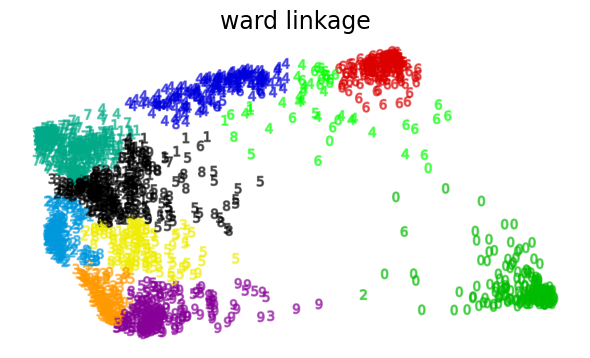

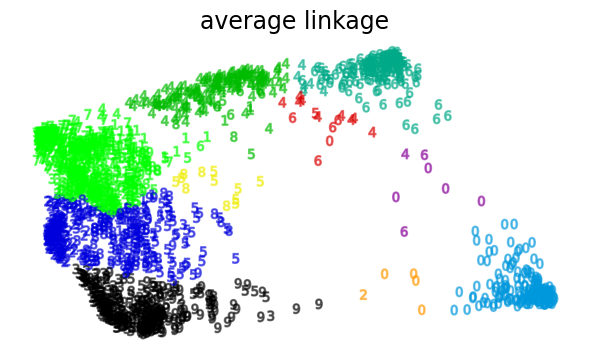

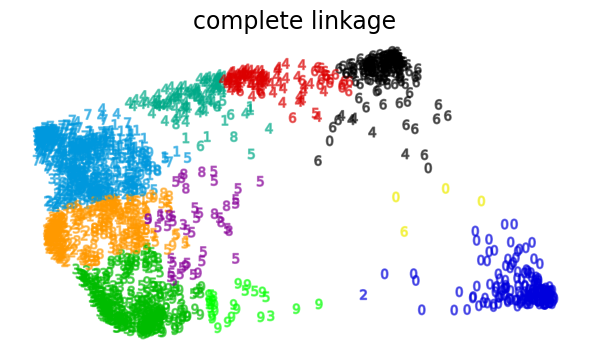

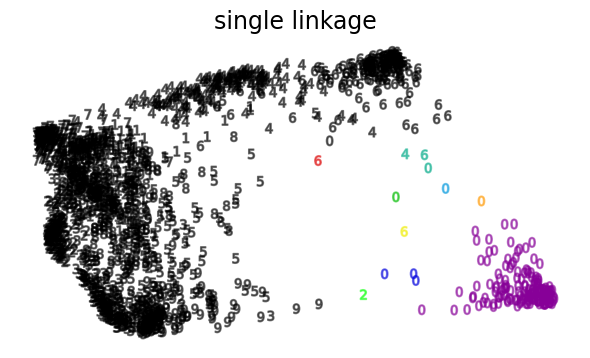

In [2]:
from time import time

import numpy as np
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

digits = datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

np.random.seed(0)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for digit in digits.target_names:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=50,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()